In [178]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import yn
from scipy.integrate import solve_ivp
from scipy.integrate import simps
from scipy.special import spherical_jn, spherical_yn
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Hand in 4

In [179]:
#Declaration of the constants
#Carbon 14
k = 1 # Example value for k
l = 1    # Example value for l
r0 = 1e-6  # Avoid singularity at r = 0
y0 = 1  # Example initial value of y at r = r0
z0 = 0.0  # Example initial value of y' at r = r0
V0 = 50
R0 = 5
mu = 867.3
h = 197.3
V0_ = 53.2
R0_ = 3.13
a = 0.67
dE = 2

## VO = 0

C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\3041722782.py:22: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol.y[0] = sol.y[0]/np.sqrt(simps(sol.y[0]**2,sol.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\3041722782.py:23: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  R_lambda_vec = R_lambda_vec/np.sqrt(simps(R_lambda_vec**2,sol.t))


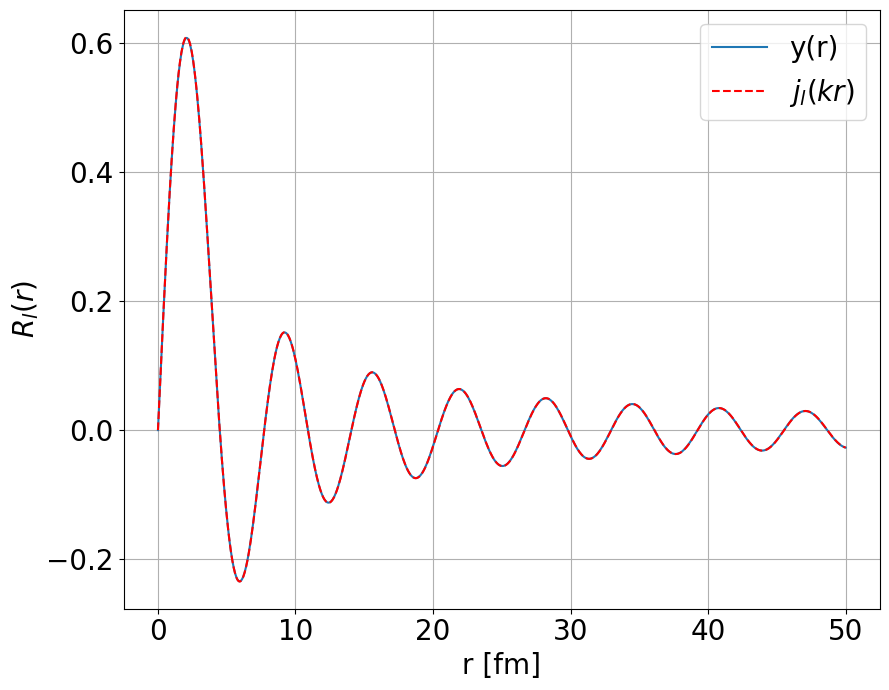

In [180]:

def spherical_bessel_first_kind(l,k, x):
    return spherical_jn(l, k*x)

def spherical_bessel_second_kind(l,k, x):
    return spherical_yn(l, k*x)

# Define the system of first-order ODEs
def system(r, Y):
    y, z = Y  # Y[0] = y, Y[1] = z (dy/dr)
    dydr = z
    dzdr = -(k**2 - l*(l+1)/r**2)*y
    return [dydr, dzdr]

initial_conditions = [y0, z0]

# Define the interval over which to solve the ODE
r_span = (r0, 50)  # Solving from r = r0 to r = 10

# Solve the ODE system
sol = solve_ivp(system, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
R_lambda_vec = sol.y[0]/sol.t
sol.y[0] = sol.y[0]/np.sqrt(simps(sol.y[0]**2,sol.t))
R_lambda_vec = R_lambda_vec/np.sqrt(simps(R_lambda_vec**2,sol.t))

A = R_lambda_vec[100]/spherical_bessel_first_kind(l, k, sol.t[100])
# Plot the solution
plt.figure(figsize=(9, 7))
plt.xlabel("r [fm]", fontsize=20)
plt.ylabel(r"$R_l(r)$", fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20) 
plt.grid(True) 
plt.plot(sol.t, R_lambda_vec, label="y(r)")
plt.plot(sol.t, A*spherical_bessel_first_kind(l, k, sol.t), 'r--', label=r"$j_l(kr)$")
# plt.plot(sol.t, spherical_bessel_second_kind(l, k, sol.t), label="y_l(kr)")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("spherical_bessel_vs_num.png")
plt.show()


## V0 attractive + repulsive 

C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\3281788351.py:92: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol2.y[0] = sol2.y[0]/np.sqrt(simps(sol2.y[0]**2,sol2.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\3281788351.py:94: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol3.y[0] = sol3.y[0]/np.sqrt(simps(sol3.y[0]**2,sol3.t))


Phase shift for attractive potential: 2.6429271530199863
Phase shift for repulsive potential: 2.942126453361869


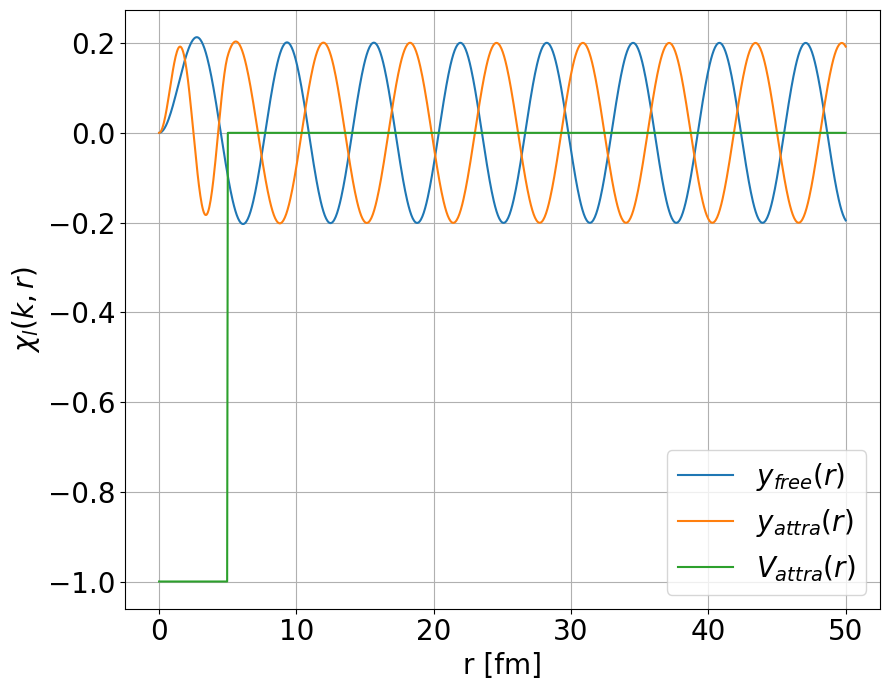

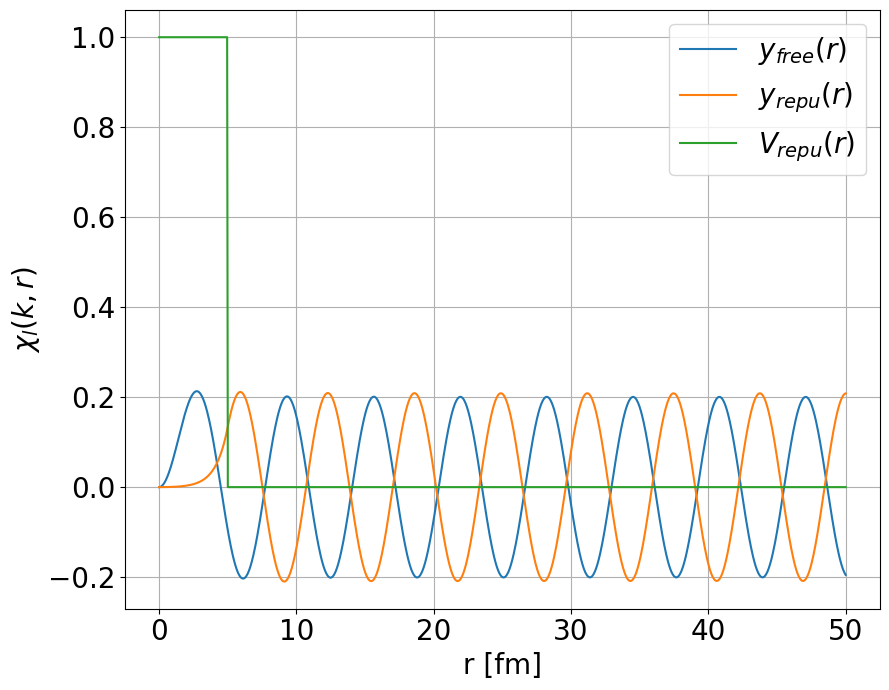

In [181]:

def V_W_attra(r,V0):
    return np.where(r < R0, -V0, 0)

def V_W_repu(r,V0):
    return -V_W_attra(r,V0)

def sinusoidal(x, A, w, phi):
        return A * np.sin(w * x + phi)

def correct_phase_signs(params):
    """Corrige les signes de A et w et ajuste la phase si nécessaire."""
    A, w, phi = params
    
    # Si A est négatif, on ajoute π à la phase et prend le module de A
    if A < 0:
        A = -A
        phi += np.pi
    
    # Si w est négatif, on ajoute π à la phase et prend le module de w
    if w < 0:
        w = -w
        phi += np.pi
    
    # Normalisation de la phase entre [-π, π]
    phi = np.mod(phi + np.pi, 2 * np.pi) - np.pi
    
    return A, w, phi
def phase_shift(x, v1, v2):
    # Find the peaks of the two vectors
    peaks_v1, _ = find_peaks(v1)
    peaks_v2, _ = find_peaks(v2)
        
    # Ensure there are at least two peaks in each vector
    if len(peaks_v1) < 2 or len(peaks_v2) < 2:
        raise ValueError("Not enough peaks found in one of the vectors.")
        
    # Calculate delta x for each vector
    delta_x_v1 = x[peaks_v1[1]] - x[peaks_v1[0]]
    delta_x_v2 = x[peaks_v2[1]] - x[peaks_v2[0]]

    # Derive the pulse using omega = 2 * pi / delta x
    omega_v1 = 2 * np.pi / delta_x_v1
    
    phase_shift1 = np.abs(omega_v1*(x[peaks_v2[1]]-x[peaks_v1[0]]))
    phase_shift2 = np.abs(omega_v1*(x[peaks_v2[1]]-x[peaks_v1[1]]))
    phase_shift3 = np.abs(omega_v1*(x[peaks_v2[0]]-x[peaks_v1[0]]))
    phase_shift4 = np.abs(omega_v1*(x[peaks_v2[0]]-x[peaks_v1[1]])) 
    # Calculate the phase shift between the two vectors
    
    phase_shift1 = np.mod(phase_shift1 + 2 * np.pi, 2 * np.pi)
    phase_shift2 = np.mod(phase_shift2 + 2 * np.pi, 2 * np.pi)
    phase_shift3 = np.mod(phase_shift3 + 2 * np.pi, 2 * np.pi)
    phase_shift4 = np.mod(phase_shift4 + 2 * np.pi, 2 * np.pi)
    return min(phase_shift1, phase_shift2, phase_shift3, phase_shift4)

# def phase_shift(x,vec1, vec2):
    
#     # Ajustement du premier vecteur avec des bornes pour A > 0, w > 0
#     params1, _ = curve_fit(sinusoidal, x[:len(x) // k], vec1[:len(x) // k], p0=[1, 1, 0])
#     params1 = correct_phase_signs(params1)
    
#     # Ajustement du second vecteur avec des bornes pour A > 0, w > 0
#     params2, _ = curve_fit(sinusoidal, x[:len(x) // k], vec2[:len(x) // k], p0=[1, 1, 0])
#     params2 = correct_phase_signs(params2)
    
#     # Extraire les phases corrigées
#     phi1 = params1[2]
#     phi2 = params2[2]
    
#     # Calculer le déphasage en tenant compte des signes
#     delta_phi = phi2 - phi1

#     # Normalisation du déphasage entre [-π, π]
#     delta_phi = np.mod(delta_phi + np.pi, 2 * np.pi) - np.pi
#     plt.plot(x[:len(x) // k], sinusoidal(x[:len(x) // k], *params2), label="vec1")
#     return delta_phi


def system2(r, Y):
    y, z = Y  # Y[0] = y, Y[1] = z (dy/dr)
    dydr = z
    dzdr = -(k**2 - l*(l+1)/r**2-2*mu*V_W_attra(r,V0)/h**2)*y
    return [dydr, dzdr]

def system3(r, Y):
    y, z = Y  # Y[0] = y, Y[1] = z (dy/dr)
    dydr = z
    dzdr = -(k**2 - l*(l+1)/r**2-2*mu*V_W_repu(r,V0)/h**2)*y
    return [dydr, dzdr]

sol2 = solve_ivp(system2, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
sol2.y[0] = sol2.y[0]/np.sqrt(simps(sol2.y[0]**2,sol2.t))
sol3 = solve_ivp(system3, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
sol3.y[0] = sol3.y[0]/np.sqrt(simps(sol3.y[0]**2,sol3.t))

phase_shift_attra = phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t > 5], sol2.y[0][sol2.t > 5])
phase_shift_repu = phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t > 5], sol3.y[0][sol3.t > 5])

print(f"Phase shift for attractive potential: {phase_shift_attra}")
print(f"Phase shift for repulsive potential: {phase_shift_repu}")

# Plot the solution for the attractive potential
plt.figure(figsize=(9, 7))
plt.xlabel("r [fm]", fontsize = 20)
plt.ylabel(r"$\chi_l(k,r)$", fontsize = 20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  
plt.grid(True)
plt.plot(sol.t, sol.y[0], label=r"$y_{free}(r)$")
plt.plot(sol2.t, sol2.y[0], label=r"$y_{attra}(r)$")
plt.plot(sol2.t,V_W_attra(sol2.t,V0)/50, label=r"$V_{attra}(r)$")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("attractive_potential_l_1.png")
plt.show()

#Plot the solution for the repulsive potential
plt.figure(figsize=(9, 7))
plt.xlabel("r [fm]", fontsize = 20)
plt.ylabel(r"$\chi_l(k,r)$", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.plot(sol.t, sol.y[0], label=r"$y_{free}(r)$")
plt.plot(sol3.t, sol3.y[0], label=r"$y_{repu}(r)$")
plt.plot(sol3.t,V_W_repu(sol3.t,V0)/50, label=r"$V_{repu}(r)$")
plt.legend(fontsize = 20)   
plt.tight_layout()
plt.savefig("repulsive_potential_l_1.png")
plt.show()

## Wood saxon

C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\415161267.py:11: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol4.y[0] = sol4.y[0]/np.sqrt(simps(sol4.y[0]**2,sol4.t))


Phase shift for Saxon potential: 2.4933275028490414


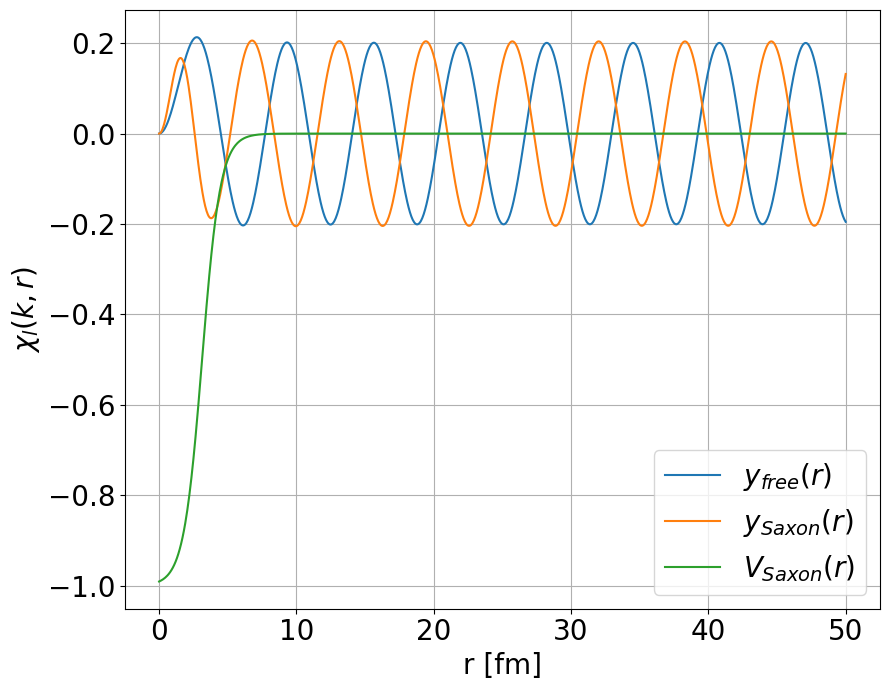

In [182]:
def V_Sax_dev(x,V0_):
    return -V0_/(1+np.exp((x-R0_)/a))

def system4(r, Y):
    y, z = Y  # Y[0] = y, Y[1] = z (dy/dr)
    dydr = z
    dzdr = -(k**2 - l*(l+1)/r**2-2*mu*V_Sax_dev(r,V0)/h**2)*y
    return [dydr, dzdr]

sol4 = solve_ivp(system4, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
sol4.y[0] = sol4.y[0]/np.sqrt(simps(sol4.y[0]**2,sol4.t))

#Calculate the phase shift
phase_shift_saxon = phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t > 5], sol4.y[0][sol4.t > 5])
print(f"Phase shift for Saxon potential: {phase_shift_saxon}")

#Plot the solution for the Saxon potential
plt.figure(figsize=(9, 7))
plt.xlabel("r [fm]", fontsize = 20)
plt.ylabel(r"$\chi_l(k,r)$", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.plot(sol.t, sol.y[0], label=r"$y_{free}(r)$")
plt.plot(sol4.t, sol4.y[0], label=r"$y_{Saxon}(r)$")
plt.plot(sol4.t,V_Sax_dev(sol4.t,V0)/50, label=r"$V_{Saxon}(r)$")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("saxon_potential_l_1.png")
plt.show()

## Evolution of the phase shift

C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\4292089795.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol.y[0] = sol.y[0]/np.sqrt(simps(sol.y[0]**2,sol.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\4292089795.py:11: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol2.y[0] = sol2.y[0]/np.sqrt(simps(sol2.y[0]**2,sol2.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\4292089795.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol3.y[0] = sol3.y[0]/np.sqrt(simps(sol3.y[0]**2,sol3.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\4292089795.py:15: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol4.y[0] = sol4.y[

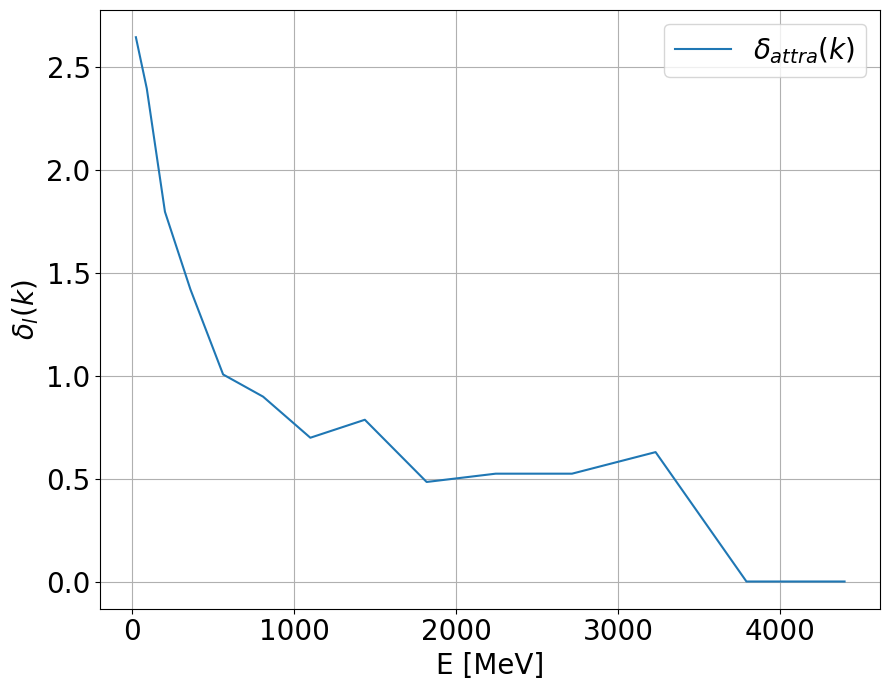

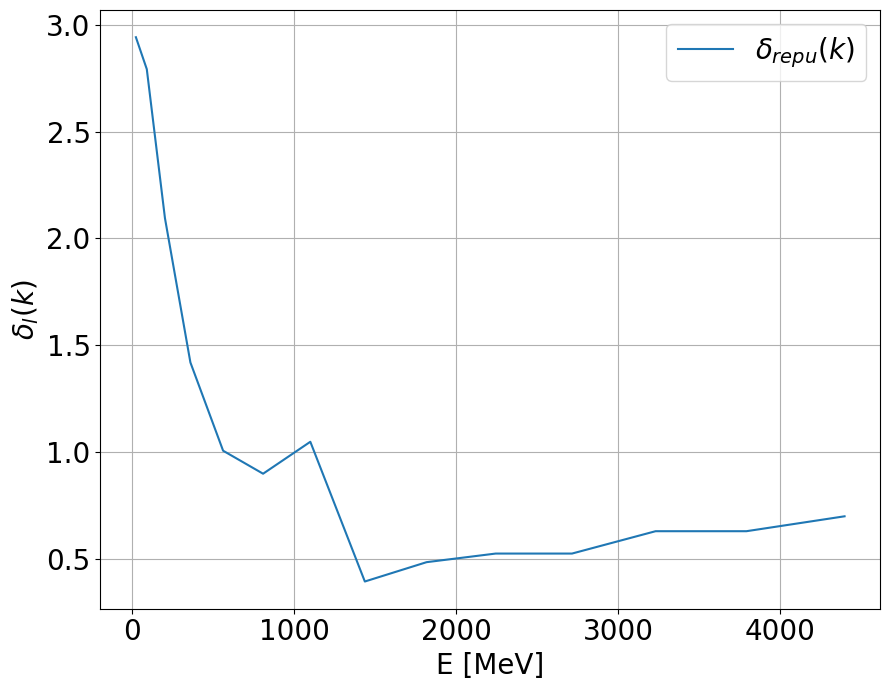

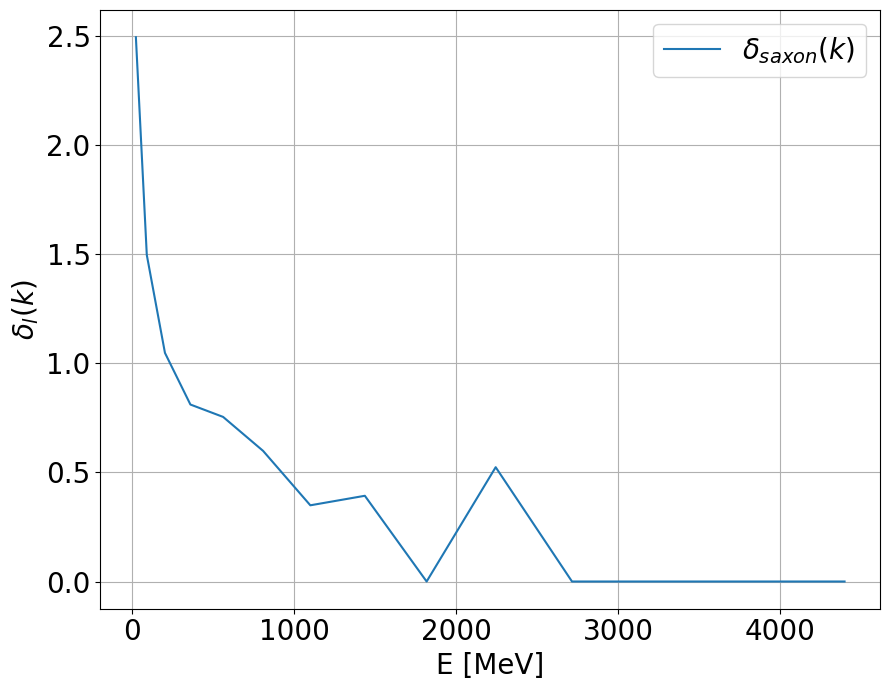

In [183]:
phase_shift_attra = []
phase_shift_repu = []
phase_shift_saxon = []
E_vec = []
for i in range(1, 15):
    k = i
    E_vec.append(h**2*k**2/(2*mu))
    sol = solve_ivp(system, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
    sol.y[0] = sol.y[0]/np.sqrt(simps(sol.y[0]**2,sol.t))
    sol2 = solve_ivp(system2, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
    sol2.y[0] = sol2.y[0]/np.sqrt(simps(sol2.y[0]**2,sol2.t))
    sol3 = solve_ivp(system3, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
    sol3.y[0] = sol3.y[0]/np.sqrt(simps(sol3.y[0]**2,sol3.t))
    sol4 = solve_ivp(system4, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
    sol4.y[0] = sol4.y[0]/np.sqrt(simps(sol4.y[0]**2,sol4.t))
    phase_shift_attra.append(phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t > 5], sol2.y[0][sol2.t > 5]))
    phase_shift_repu.append(phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t > 5], sol3.y[0][sol3.t > 5]))
    phase_shift_saxon.append(phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t > 5], sol4.y[0][sol4.t > 5]))

# Attra phase shift
plt.figure(figsize=(9, 7))
plt.xlabel("E [MeV]", fontsize = 20)
plt.ylabel(r"$\delta_l(k)$", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.plot(E_vec, phase_shift_attra, label=r"$\delta_{attra}(k)$")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("phase_shift_attra.png")
plt.show()

# Repu phase shift
plt.figure(figsize=(9, 7))
plt.xlabel("E [MeV]", fontsize = 20)
plt.ylabel(r"$\delta_l(k)$", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.plot(E_vec, phase_shift_repu, label=r"$\delta_{repu}(k)$")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("phase_shift_repu.png")
plt.show()

# Saxon phase shift
plt.figure(figsize=(9, 7))
plt.xlabel("E [MeV]", fontsize = 20)
plt.ylabel(r"$\delta_l(k)$", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.plot(E_vec, phase_shift_saxon, label=r"$\delta_{saxon}(k)$")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("phase_shift_saxon.png")
plt.show()

C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\3974136819.py:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol.y[0] = sol.y[0]/np.sqrt(simps(sol.y[0]**2,sol.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\3974136819.py:12: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol2.y[0] = sol2.y[0]/np.sqrt(simps(sol2.y[0]**2,sol2.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\3974136819.py:14: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol3.y[0] = sol3.y[0]/np.sqrt(simps(sol3.y[0]**2,sol3.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\3974136819.py:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol4.y[0] = sol4.y

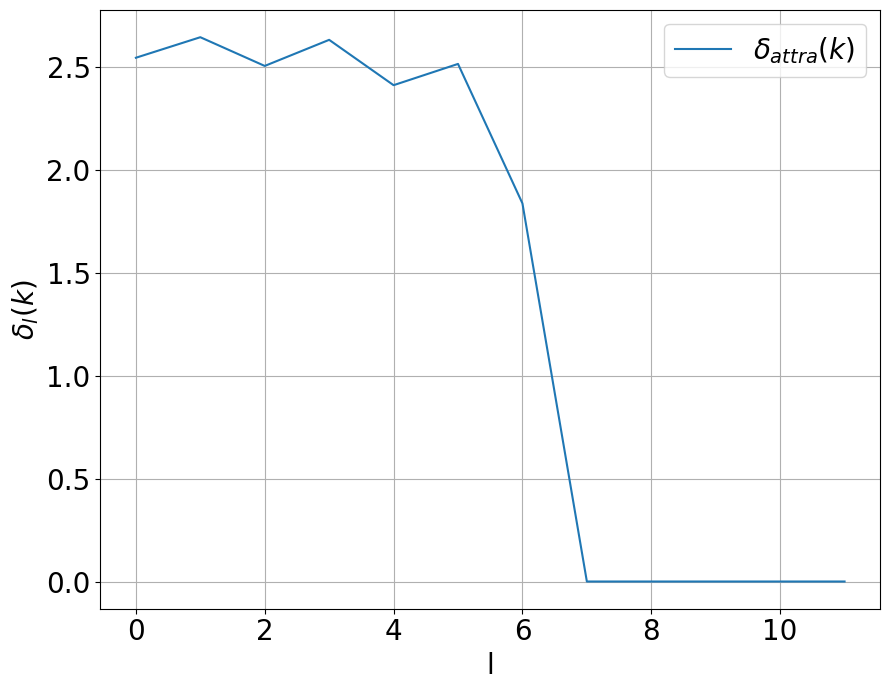

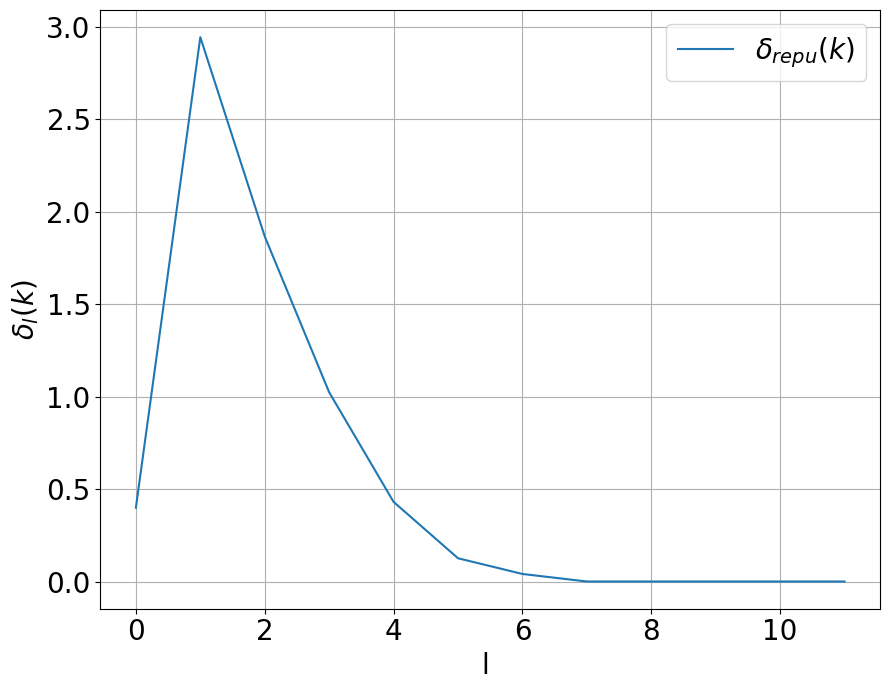

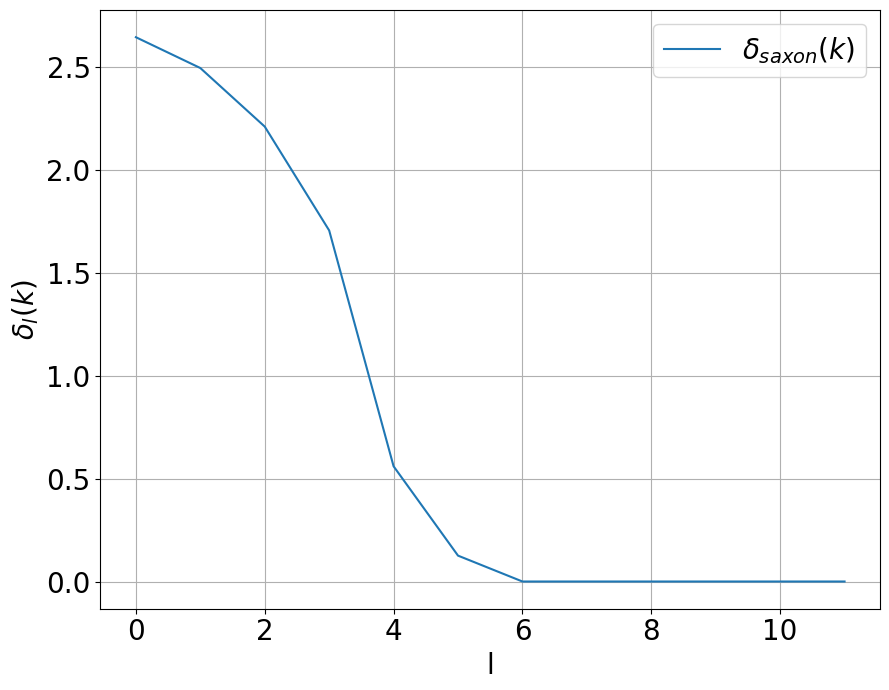

In [184]:
phase_shift_attra_l = []
phase_shift_repu_l = []
phase_shift_saxon_l = []
k = 1
l_vec = []
for i in range(0, 12):
    l = i
    l_vec.append(l)
    sol = solve_ivp(system, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
    sol.y[0] = sol.y[0]/np.sqrt(simps(sol.y[0]**2,sol.t))
    sol2 = solve_ivp(system2, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
    sol2.y[0] = sol2.y[0]/np.sqrt(simps(sol2.y[0]**2,sol2.t))
    sol3 = solve_ivp(system3, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
    sol3.y[0] = sol3.y[0]/np.sqrt(simps(sol3.y[0]**2,sol3.t))
    sol4 = solve_ivp(system4, r_span, initial_conditions, t_eval=np.linspace(r0, 50, 1000))
    sol4.y[0] = sol4.y[0]/np.sqrt(simps(sol4.y[0]**2,sol4.t))
    phase_shift_attra_l.append(phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t > 5], sol2.y[0][sol2.t > 5]))
    phase_shift_repu_l.append(phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t >5], sol3.y[0][sol3.t > 5]))
    phase_shift_saxon_l.append(phase_shift(sol.t[sol.t > 5],sol.y[0][sol.t > 5], sol4.y[0][sol4.t > 5]))

# Attra phase shift
plt.figure(figsize=(9, 7))
plt.xlabel("l", fontsize = 20)
plt.ylabel(r"$\delta_l(k)$", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.plot(l_vec, phase_shift_attra_l, label=r"$\delta_{attra}(k)$")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("phase_shift_attra_l.png")
plt.show()

# Repu phase shift
plt.figure(figsize=(9, 7))
plt.xlabel("l ", fontsize = 20)
plt.ylabel(r"$\delta_l(k)$", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.plot(l_vec, phase_shift_repu_l, label=r"$\delta_{repu}(k)$")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("phase_shift_repu_l.png")
plt.show()

# Saxon phase shift
plt.figure(figsize=(9, 7))
plt.xlabel("l", fontsize = 20)
plt.ylabel(r"$\delta_l(k)$", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.plot(l_vec, phase_shift_saxon_l, label=r"$\delta_{saxon}(k)$")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("phase_shift_saxon_l.png")
plt.show()

C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\1786338817.py:14: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  sol.y[0] = sol.y[0]/np.sqrt(simps(sol.y[0]**2,sol.t))
C:\Users\rapha\AppData\Local\Temp\ipykernel_28632\1786338817.py:15: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  R_lambda_vec = R_lambda_vec/np.sqrt(simps(R_lambda_vec**2,sol.t))


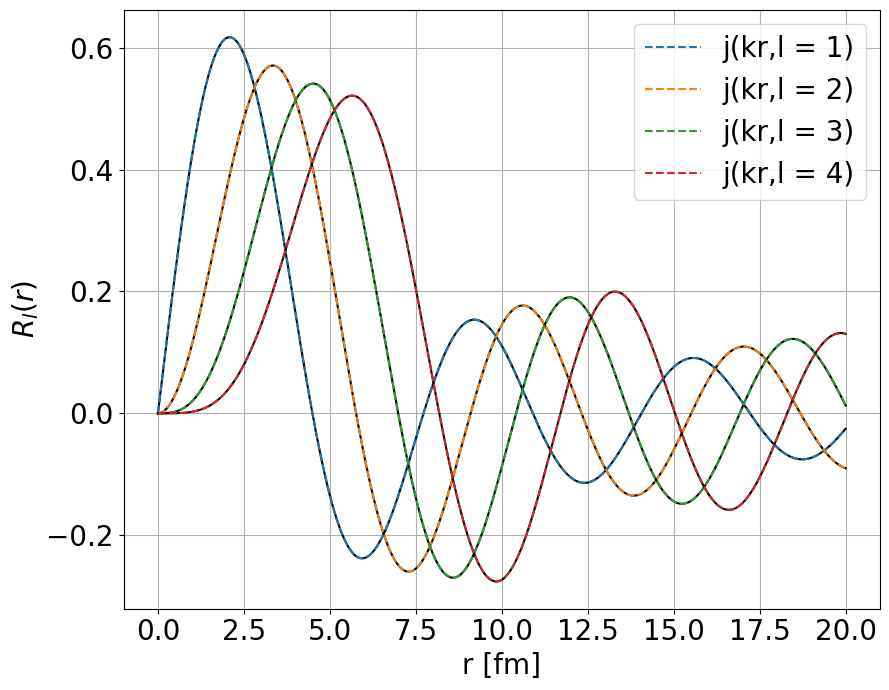

In [185]:
# Free case for different l = 1,...,5
k = 1
# Plot the solution
plt.figure(figsize=(9, 7))
plt.xlabel("r [fm]", fontsize=20)
plt.ylabel(r"$R_l(r)$", fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20) 
plt.grid(True) 
for l in range(1, 5):
# Solve the ODE system
    sol = solve_ivp(system, r_span, initial_conditions, t_eval=np.linspace(r0, 20, 1000))
    R_lambda_vec = sol.y[0]/sol.t
    sol.y[0] = sol.y[0]/np.sqrt(simps(sol.y[0]**2,sol.t))
    R_lambda_vec = R_lambda_vec/np.sqrt(simps(R_lambda_vec**2,sol.t))

    A = R_lambda_vec[100]/spherical_bessel_first_kind(l, k, sol.t[100])

    plt.plot(sol.t, R_lambda_vec,color = "black")
    plt.plot(sol.t, A*spherical_bessel_first_kind(l, k, sol.t), '--', label=f"j(kr,l = {l})")
# plt.plot(sol.t, spherical_bessel_second_kind(l, k, sol.t), label="y_l(kr)")
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("spherical_bessel_vs_num_row.png")
plt.show()